In [82]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

test = pd.read_csv('Data/test.csv')
train = pd.read_csv('Data/train.csv')

In [83]:
import seaborn as sns
sns.set(color_codes=True)

In [84]:
test['file'] = 'test'
test['SalePrice'] = np.nan
train['file'] = 'train'

In [85]:
test_names = test.columns
train_names = train.columns

names_match = set(test_names) & set(train_names)

print('Length of columns in test (%s), train (%s) and the number that match between the two (%s)' %(len(test_names), len(train_names), 
                                                                                              len(names_match)))

Length of columns in test (82), train (82) and the number that match between the two (82)


In [86]:
frames = [train, test]

print ('Combining test and train into one long dataset for analysis. Please note that absence of sale price = NaN')
ttl_df = pd.concat(frames)

print ('Test was %s rows long, train was %s and the combined df is %s rows long' % (test.shape[0], train.shape[0], 
                                                                                    ttl_df.shape[0]))

Combining test and train into one long dataset for analysis. Please note that absence of sale price = NaN
Test was 1459 rows long, train was 1460 and the combined df is 2919 rows long


In [87]:
print ('Working on the categorical varaiables. Man this is gonna suck')

s = pd.Series(pd.Categorical(ttl_df['MSSubClass']))

cats = ['1-STORY 1946 & NEWER ALL STYLES', '1-STORY 1945 & OLDER',
        '1-STORY W/FINISHED ATTIC ALL AGES', '1-1/2 STORY - UNFINISHED ALL AGES',
        '1-1/2 STORY FINISHED ALL AGES', '2-STORY 1946 & NEWER',
        '2-STORY 1945 & OLDER','2-1/2 STORY ALL AGES',
        'SPLIT OR MULTI-LEVEL', 'SPLIT FOYER',
       'DUPLEX - ALL STYLES AND AGES', '1-STORY PUD (Planned Unit Development) - 1946 & NEWER',
       '1-1/2 STORY PUD - ALL AGES', '2-STORY PUD - 1946 & NEWER',
       'PUD - MULTILEVEL - INCL SPLIT LEV/FOYER', '2 FAMILY CONVERSION - ALL STYLES AND AGES']

s.cat.categories = cats
ttl_df['MSSubClass_cat'] = s

Working on the categorical varaiables. Man this is gonna suck


## hypothesis: do houses that commonly have additional features (such as being referred to in feature category 2) consistently get higher sale prices?

### Now going to look at the impact of types of finish on the houses

In [88]:
analysis_sale = ttl_df.loc[lambda df: df.file == 'train', :]

print(analysis_sale.Exterior1st.value_counts())
print(analysis_sale.Exterior2nd.value_counts())

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
CBlock       1
ImStucc      1
AsphShn      1
Name: Exterior1st, dtype: int64
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64


In [89]:
train.shape

(1460, 82)

In [90]:
ext1st = analysis_sale.Exterior1st.value_counts().reset_index()
ext2nd = analysis_sale.Exterior2nd.value_counts().reset_index()

print ('The first exterior category has %s observations, while the second has %s ' % (ext1st['Exterior1st'].sum(),
                                                                                    ext2nd['Exterior2nd'].sum()))

The first exterior category has 1460 observations, while the second has 1460 


### I feel that it's unlikely that every house in this dataset has two different finishes applied to each house, so I'm gonna go out on a limb and say that a number of these observations in the second group are the same as in the first. Let's see if thats the case..

In [91]:
analysisExt = ttl_df.loc[lambda df: df.Exterior1st == df.Exterior2nd, :]

print('Number of observations in the main dataset %s, %s of these observations that have the same exterior material' % (ttl_df.shape[0], analysisExt.shape[0]))

Number of observations in the main dataset 2919, 2481 of these observations that have the same exterior material


### Wooooo - that seems to be the case. Now I want to create a variable that captures whether a house has a different exterior material from the first

In [92]:
def unique_options(x, y):
    x = str(x)
    y = str(y)
    if x == y: return 0
    return 1

ttl_df['Mult_Ext'] = ttl_df.apply(lambda x: unique_options(x['Exterior1st'], x['Exterior2nd']), axis=1)
ttl_df['Mult_conds'] = ttl_df.apply(lambda x: unique_options(x['Condition1'], x['Condition2']), axis = 1)
ttl_df['Remodelled'] = ttl_df.apply(lambda x: unique_options(x['YearBuilt'], x['YearRemodAdd']), axis = 1)

### Now we've got the flag that determines whether a unique condition occurs, we'll want to go and understand which unique options are being used

In [93]:
def second_recode(x, y):
        
    if y == 1: return x
    else: return np.nan

ttl_df['Exterior2nd'] = ttl_df.apply(lambda x: second_recode(x['Exterior2nd'], x['Mult_Ext']), axis = 1)
ttl_df['Condition2'] = ttl_df.apply(lambda x: second_recode(x['Condition2'], x['Mult_conds']), axis = 1)
ttl_df['YearRemodAdd'] = ttl_df.apply(lambda x: second_recode(x['YearRemodAdd'], x['Remodelled']), axis = 1)

In [94]:
ttl_df.YearRemodAdd.value_counts()

1950.0    339
2006.0    113
2007.0     83
2005.0     75
2000.0     62
2004.0     54
2008.0     44
2002.0     44
2003.0     43
1995.0     43
1998.0     43
1996.0     42
1994.0     38
1997.0     33
1999.0     30
2001.0     27
1993.0     26
1991.0     22
1990.0     20
2009.0     18
1992.0     17
1987.0     11
1989.0     11
2010.0     10
1980.0      9
1975.0      9
1970.0      8
1985.0      8
1988.0      7
1982.0      6
1981.0      5
1965.0      5
1979.0      5
1972.0      4
1958.0      4
1984.0      4
1986.0      4
1983.0      4
1973.0      3
1978.0      3
1960.0      3
1976.0      2
1955.0      2
1963.0      2
1968.0      2
1969.0      2
1966.0      1
1977.0      1
1974.0      1
1962.0      1
1959.0      1
1971.0      1
1954.0      1
1953.0      1
1952.0      1
1967.0      1
Name: YearRemodAdd, dtype: int64

## Now will want to combine different size measures into one total measure. Will want to check what happens to the second size categories when the house doesn't have any second floor. Who knows - maybe some weird shit might happen

In [95]:
analysis_table = ttl_df.loc[ttl_df.HouseStyle == '1Story', :]
analysis_table['2ndFlrSF'].value_counts()

0      1468
467       1
192       1
144       1
Name: 2ndFlrSF, dtype: int64

## Faaaaaaaar I'm lucky that I checked this because there is either errors in the SF measurement or they aren't truly 1story houses. 

## Since these have been measured I'm going to recode these to 'possible second floors'

In [96]:
def floor_error(x, y):
    x = str(x)
    if x.find('1Story') == 0 and y > 0: return 'Pos2ndfloor'
    else: return x

ttl_df['HouseStyle_recode'] = ttl_df.apply(lambda x: floor_error(x['HouseStyle'], x['2ndFlrSF']), axis=1)

In [97]:
def ttl_cols(x, y):
    return x + y

ttl_df['ttl_floor_SF'] = ttl_df.apply(lambda x: x['1stFlrSF'] + x['2ndFlrSF'] + x['BsmtFinSF1'] + x['BsmtFinSF2'], axis = 1)
ttl_df['ttl_bath'] = ttl_df.apply(lambda x:  x['BsmtFullBath'] + 0.5 * x['BsmtHalfBath'] + x['FullBath'] + 0.5 * x['HalfBath'], axis = 1)

## Now wanting to look atM the years since remodel. Maybe something interesting will fall out?

In [98]:
ttl_df['YearBuilt'].value_counts()

2005    142
2006    138
2007    109
2004     99
2003     88
1977     57
1920     57
1976     54
1999     52
2008     49
1958     48
2000     48
2002     47
1998     46
1968     45
1959     43
1954     43
1910     43
1970     42
1967     41
1972     40
1956     39
1971     39
1978     39
1993     39
1950     38
1994     37
1960     37
1940     36
1966     35
       ... 
1982      7
1931      7
1985      7
1942      6
1912      5
1919      5
1932      5
1880      5
1934      5
2010      3
1905      3
1895      3
1917      3
1908      2
1885      2
1901      2
1892      2
1882      1
1896      1
1898      1
1902      1
1907      1
1904      1
1906      1
1913      1
1911      1
1875      1
1879      1
1893      1
1872      1
Name: YearBuilt, dtype: int64

## I think that using this variable would be pretty misleading as it doesn't reflect the current state of the house (remodel date will likely do that). That being said, you would expect that some of the oldest houses probably include large plots of land too..

In [99]:
ttl_df['Remodelled'].value_counts()

0    1560
1    1359
Name: Remodelled, dtype: int64

## Now I probably want to look the number of years between sale and remodel date to get a better idea of which houses were in a 'new' condition by the sale date

In [100]:
ttl_df['YearsSinceRemodel'] = ttl_df.apply(lambda x: x.YrSold - x.YearRemodAdd, axis=1)

In [101]:
ttl_df.YearsSinceRemodel.value_counts()

 0.0     124
 56.0     91
 1.0      85
 59.0     71
 58.0     68
 57.0     68
 3.0      60
 2.0      59
 4.0      58
 8.0      55
 5.0      54
 60.0     42
 9.0      41
 12.0     40
 13.0     39
 10.0     38
 6.0      38
 7.0      37
 11.0     36
 14.0     34
 16.0     30
 15.0     25
 17.0     19
 19.0     11
 20.0     11
 18.0      9
 27.0      9
 21.0      8
 23.0      7
 22.0      7
 26.0      7
 25.0      6
 28.0      5
 44.0      5
 31.0      5
 32.0      5
 36.0      5
 38.0      5
 33.0      4
 39.0      4
 48.0      4
 24.0      3
 29.0      3
 34.0      3
 43.0      3
 53.0      2
 51.0      2
 50.0      2
-1.0       2
 35.0      2
 30.0      2
 47.0      1
 41.0      1
 49.0      1
-2.0       1
 55.0      1
 40.0      1
Name: YearsSinceRemodel, dtype: int64

## Interestingly there's a couple negative years included in the dataset, indicating that the remodel year was more recent than the sale year. Which doesn't make much sense if this data was collected at sale time

In [102]:
recent_threshold = 10

def recent_remodel(x, y):
    if x >= y: return 1
    else: return 0
    
ttl_df['HouseStyle_recode'] = ttl_df.apply(lambda x: floor_error(x['HouseStyle'], x['2ndFlrSF']), axis=1)    
ttl_df['recent_remodel'] = ttl_df.apply(lambda x: recent_remodel(x['YearsSinceRemodel'], recent_threshold), axis=1)

ttl_df.loc[lambda df: df.YearsSinceRemodel < 0, :]

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,file,MSSubClass_cat,Mult_Ext,Mult_conds,Remodelled,HouseStyle_recode,ttl_floor_SF,ttl_bath,YearsSinceRemodel,recent_remodel
523,3138,1538,0,NaN,3,1Fam,TA,Gd,2260.0,0.0,...,train,2-STORY 1946 & NEWER,1,0,1,2Story,6936.0,4.5,-1.0,0
835,1582,570,0,NaN,3,1Fam,TA,No,0.0,0.0,...,test,1-STORY 1946 & NEWER ALL STYLES,0,0,1,2Story,2152.0,2.5,-1.0,0
1089,5095,0,0,NaN,2,1Fam,TA,Gd,4010.0,0.0,...,test,1-STORY PUD (Planned Unit Development) - 1946 ...,1,0,1,1Story,9105.0,4.0,-2.0,0


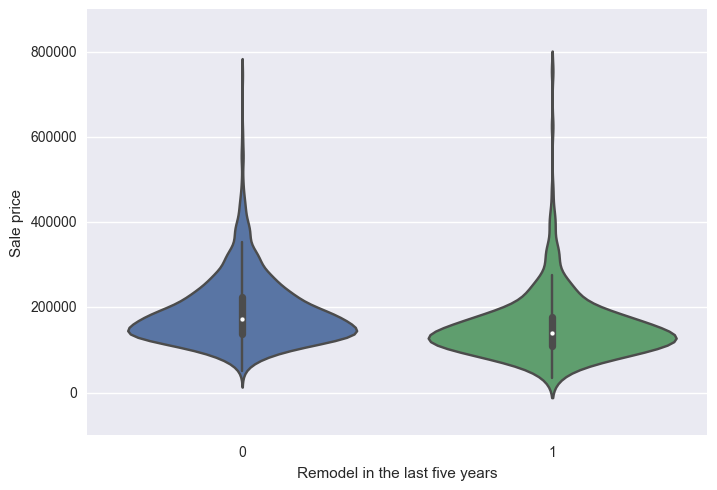

In [103]:
graph_df = ttl_df.loc[lambda df: df.file == 'train', :]

ax = sns.violinplot(x="recent_remodel", y="SalePrice", data=graph_df)
ax.set(xlabel='Remodel in the last five years', ylabel = 'Sale price')
plt.show()

## Now I'm gonna look at some aggregate features to include to the dataset. Mainly gonna use means/medians here

In [112]:
grouped = ttl_df.loc[ttl_df['file'] == 'train', :].groupby('Neighborhood')
med_neighbour_sale = grouped.SalePrice.median().reset_index()

med_neighbour_sale.rename(columns = {'SalePrice':'AreaAverage'}, inplace = True)

In [113]:
ttl_df = pd.merge(ttl_df, med_neighbour_sale, how = 'left', on='Neighborhood')